# Face Mask Detection using YOLOv5

Complementary notebook for the blog post [Face Mask Detection using YOLOv5](https://towardsdatascience.com/face-mask-detection-using-yolov5-3734ca0d60d8)

### Changing the labels of the annotations:

In [35]:
import re
import os

In [132]:
for folder in ['train', 'val']:
    file_list = os.listdir(f'./{folder}')
    for file in file_list:
        if not file.endswith('.txt'):
            continue
        with open(f'./{folder}/{file}', 'r+') as f:
            lines = f.read()
            replaced = re.sub(r'0(?=\s\d+\.\d+){4}', '1', lines)
            replaced = re.sub(r'2(?=\s\d+\.\d+){4}', '0', lines)
            f.seek(0)
            f.write(replaced)
            f.truncate()

### Downloading images from the COCO dataset

In [2]:
from pycocotools.coco import COCO
import requests

In [3]:
path = r'C:\work\mask_detector\old_stuff\yolo5\annotations\instances_val2014.json'

In [4]:
coco = COCO(path)

loading annotations into memory...
Done (t=7.80s)
creating index...
index created!


In [5]:
coco.getCatIds(catNms=['person'])

[1]

In [6]:
catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)

In [7]:
images = coco.loadImgs(imgIds)

URL and relevant data from the images

In [33]:
print(len(images))
images[0]

21634


{'license': 1,
 'file_name': 'COCO_val2014_000000262148.jpg',
 'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000262148.jpg',
 'height': 512,
 'width': 640,
 'date_captured': '2013-11-20 05:50:03',
 'flickr_url': 'http://farm5.staticflickr.com/4028/4549977479_547e6b22ae_z.jpg',
 'id': 262148}

Download a subset of the images via `request`:

In [15]:
for im in images[10:30]: # select as many as you'll need
    img_data = requests.get(im['coco_url']).content
    with open('./coco_images/' + im['file_name'], 'wb') as handler:
        handler.write(img_data)

----

### Face detection using MTCNN 

In [18]:
from facenet_pytorch import MTCNN, extract_face
import matplotlib.image as mpl
import matplotlib.pyplot as plt
import os

In [23]:
import cv2

In [24]:
mtcnn = MTCNN(keep_all=True)

In [25]:
path = r'C:\work\mask_detector\old_stuff\yolo5\coco_images'
labels_path = r'C:\work\mask_detector\old_stuff\yolo5\coco_labels'
ims = os.listdir(path)

In [26]:
len(ims)

20

In [31]:
def convert_to_darknet(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

COCO_val2014_000000131152.jpg


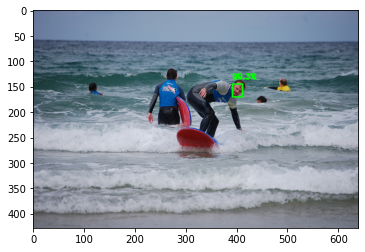

COCO_val2014_000000262200.jpg


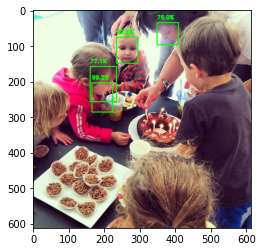

COCO_val2014_000000262229.jpg


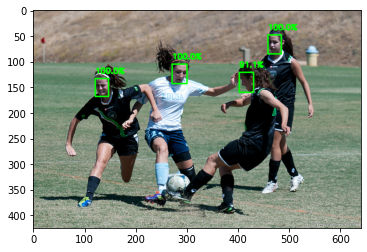

COCO_val2014_000000262235.jpg


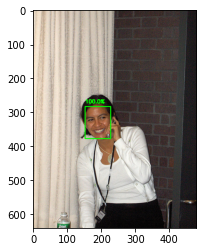

COCO_val2014_000000262275.jpg


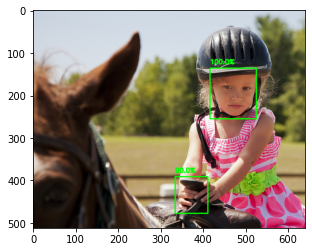

COCO_val2014_000000393284.jpg


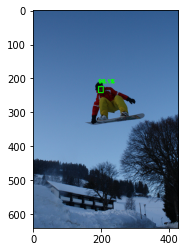

COCO_val2014_000000393372.jpg


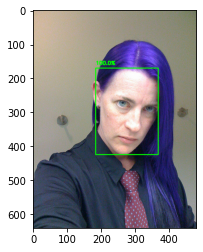

COCO_val2014_000000524431.jpg


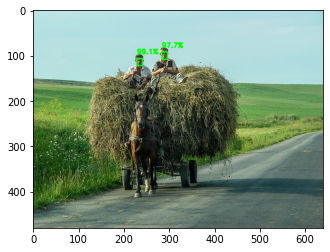

COCO_val2014_000000524436.jpg


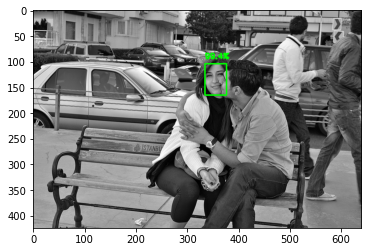

In [30]:
path = r'.\coco_images'
labels_path = r'.\coco_labels'
ims = os.listdir(path)

ignored_ones = []

for img in ims:

    im_path = path+'\\'+img
    im = mpl.imread(im_path)

    try:
        boxes, probs, points = mtcnn.detect(im, landmarks=True)
    except RuntimeError as e:
        print("Oops, can't detect?")
        n_boxes.append(im_path)
    if boxes is not None:

        for box, prob in zip(boxes, probs):
            startX, startY, endX, endY = box.astype(int)

            color = (0,255,0) 
            cv2.putText(im, 
                        f'{prob:.1%}', 
                        (startX, startY - 10), 
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=.5, 
                        color=color,
                        thickness=2)
            cv2.rectangle(im, (startX, startY), (endX, endY), color, 2) 

        w= int(im.shape[0])
        h= int(im.shape[1])

        label = img.rstrip('.jpg')
        with open(rf'{labels_path}\{label}.txt', 'w') as f:
            for item in boxes:
                b = (startX, endX, startY, endY)
                bb = convert((w,h), b)
                box = ' '.join(item.astype(str))
                f.write(f"0 {box}\n")
        print(img)
        plt.imshow(im)
        plt.show()

    else:
        ignored_ones.append(im_path)